In [1]:
import pickle
import numpy as np
import math
import pandas as pd
from model import NN_with_embedding
from keras.models import load_model, model_from_json
import keras.backend as K
import tensorflow as tf
sess = tf.Session()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/anaconda3/envs/udacity_tensorflow_py3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/envs/udacity_tensorflow_py3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [8]:
num_network = 1
testing = True
#if testing is true, will generate prediction.csv on testing set. if it's false, will return the metrics on dummy test set

with open("X_dummy_test.pickle","rb") as f:
    (X_dummy_test,target_dummy_test) = pickle.load(f)

with open("X_test.pickle","rb") as f:
    X_test = pickle.load(f)

with open("X_train.pickle","rb") as f:
    (X_train, target_train) = pickle.load(f)
    
with open("X_all_train.pickle","rb") as f:
    (X_all_train, target_all) = pickle.load(f)

with open("combined_data_test.pickle","rb") as f:
    df_combined_test = pickle.load(f)

In [9]:
models = []

for i in range(num_network):
    model = load_model("/Users/Robin/Desktop/udacity_ml/Rossman_store/robin/models/model_18/model{}.h5".format(i))
    models.append(model)

In [4]:
def evaluate(y_pred, y_true):
    rmspe = np.sqrt(np.mean(np.square((y_true - y_pred)/y_true)))
    accuracy = np.mean(np.abs((y_true-y_pred)/y_true))
    return rmspe, accuracy

In [5]:
def reverse_log_target(y,target_train):
    #target_train was used in NN_with_embedding to come up with max_log_y for normalization
    max_log_y = np.max(np.log(target_train))
    result = K.exp(y * max_log_y)
    return result

In [6]:
def plot_result(history):
    train_loss = history["loss"]
    val_loss = history["val_loss"]
    iters = np.array(range(len(train_loss)))+1
    plt.figure()
    plt.plot(iters, train_loss, 'r', label='train loss')
    plt.plot(iters, val_loss, 'g', label='val loss')
    plt.grid(True)
    plt.xlabel("epoch")
    plt.ylabel('loss')
    plt.legend(loc="upper right")
    plt.show()

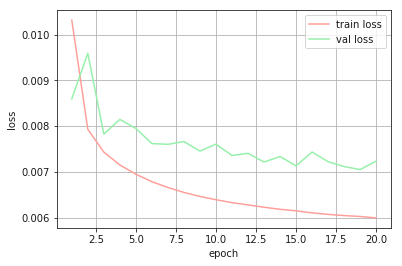

In [18]:
with open("/Users/Robin/Desktop/udacity_ml/Rossman_store/robin/models/model_10/history.pickle","rb") as f:
    hist = pickle.load(f)
sns.set_color_codes("pastel")
plot_result(hist[0])

In [13]:
if testing:
    guesses = []
    for i in range(num_network):
        guess = reverse_log_target(models[i].predict(X_test),target_all)
        guess = guess.eval(session=sess)
        guess = guess.astype(int).squeeze()
        guess = guess[::-1]
        guesses.append(guess)
    combined_guess = np.mean(np.array(guesses),axis=0).squeeze()
    
    #test_open: 0 is not open, 1 is open
    test_open = df_combined_test["Open"]
    test_open = np.array(test_open).squeeze()
    test_open = test_open[::-1]
    
    with open('predictions.csv', 'w') as f:
        f.write('Id,Sales\n')
        for i, record in enumerate(combined_guess):
            if test_open[i]:
                guessed_sales = record
            else:
                guessed_sales = 0
            f.write('{},{}\n'.format(i+1, guessed_sales))
    
else:
    guesses = []
    for i in range(num_network):
        guess = reverse_log_target(models[i].predict(X_dummy_test),target_train)
        guess = guess.eval(session=sess)
        guess = guess.astype(int).squeeze()
        guesses.append(guess)
        rmspe, accuracy = evaluate(guess,target_dummy_test)
        print("Model {} RMSPE: {}, Accuracy: {}".format(i+1,rmspe,accuracy))
    combined_guess = np.mean(np.array(guesses),axis=0).squeeze()
    rmspe, accuracy = evaluate(combined_guess,target_dummy_test)
    print("Combined Model RMSPE: {}, Accuracy: {}\n".format(rmspe,accuracy))
    display(hist)